In [3]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506032030_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506032030_0


In [4]:
class MultiBasisDataLoader:
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):

        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        self._bases = list(data_dict.keys())
        self._arrays = list(data_dict.values())

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0) # (N_B, n_visible)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [5]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [10]:
#### SOME HELPER FUNCTIONS

def get_computational_basis_vectors(num_qubits: int) -> jnp.ndarray:
    indices = jnp.arange(2 ** num_qubits, dtype=jnp.uint32)  # shape (2**n,)
    powers = 2 ** jnp.arange(num_qubits - 1, -1, -1, dtype=jnp.uint32)  # shape (n,)
    bits = (indices[:, None] & powers) > 0  # shape (2**n, n), bool
    return bits.astype(jnp.float32)

from functools import reduce

def construct_rotation_matrix(measurement_basis: jnp.ndarray) -> jnp.ndarray:
    SQRT2 = jnp.sqrt(2.0)
    single_qubit_rotation_matrices = jnp.stack([
        jnp.array([[1, 0], [0, 1]], dtype=jnp.complex64),               # Z
        jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2,      # X
        jnp.array([[1, -1j], [1j, -1]], dtype=jnp.complex64) / SQRT2    # Y
    ])  # (3, 2, 2)

    gates = single_qubit_rotation_matrices[measurement_basis]  # (n, 2, 2)

    def kron_all(a, b):
        return jnp.kron(a, b)

    return reduce(kron_all, gates)

def bitstring_to_int(bitstring: jnp.ndarray) -> jnp.ndarray:
    powers = 2 ** jnp.arange(bitstring.shape[-1] - 1, -1, -1)
    return jnp.sum(bitstring * powers, axis=-1).astype(jnp.int32)



class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    # ---------- variables ----------
    def setup(self):
        zeros = lambda s: jnp.zeros(s, jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01),
                                (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    # ---------- helpers ----------
    def _free_energy_amp(self, v):
        W = self.get_variable('amp', 'W_amp')
        b = self.get_variable('amp', 'b_amp')
        c = self.get_variable('amp', 'c_amp')
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), axis=-1)


    # ---------- single-sample loss (scalar) ----------
    def single_loss(self, basis: jnp.ndarray, sample: jnp.ndarray) -> jnp.ndarray:
        # basis:  (n,)  values 0/1/2  = Z/X/Y
        # sample: (n,)  0/1 bitstring
        n = basis.shape[0]

        comp_vecs = get_computational_basis_vectors(n)              # (2**n, n)
        F_amp = jax.vmap(self._free_energy_amp)(comp_vecs)          # (2**n,)
        F_pha = jax.vmap(self._free_energy_pha)(comp_vecs)

        U = construct_rotation_matrix(basis)                        # (2**n, 2**n)
        col_idx = bitstring_to_int(sample)                          # scalar
        amps = U[col_idx]                                           # (2**n,)

        def rotated_log_prob(amps, F_amp, F_pha):
            z = amps * jnp.exp(-0.5*F_amp - 0.5j*F_pha)           # (2**n,)
            m = jnp.max(jnp.log(jnp.abs(z) + 1e-30))
            return 2 * (m + jnp.log(jnp.abs(jnp.sum(z * jnp.exp(-m))) + 1e-30))

        return -rotated_log_prob(amps, F_amp, F_pha)  # scalar

In [11]:

from jax.flatten_util import ravel_pytree
 # replace with your actual import

from jax.flatten_util import ravel_pytree

from jax.flatten_util import ravel_pytree

@jax.jit
def train_step_natural(state, amp_vars, data_tuple, lr=1e-3, eps=1e-5):
    bases, data = data_tuple        # (N_B, n), (N_B, B, n)

    # full batch loss (for logging)
    def full_loss(params):
        per_basis = jax.vmap(                       # over bases
            lambda b, xs: jax.vmap(                # over B measurements
                lambda x: state.apply_fn(
                    {'params': params, 'amp': amp_vars},
                    method=PairPhaseRBM.single_loss,
                    basis=b, sample=x))(xs)
        )(bases, data)                             # shape (N_B, B)
        return jnp.mean(per_basis)

    loss_val = full_loss(state.params)

    # per-sample grads → (N_B, B, …) pytree
    grad_fn = jax.vmap(jax.vmap(
        lambda b, x: jax.grad(
            lambda p: state.apply_fn(
                {'params': p, 'amp': amp_vars},
                method=PairPhaseRBM.single_loss,
                basis=b, sample=x))(state.params)),
        in_axes=(0, 0))                            # map over bases then samples
    per_g = grad_fn(bases, data)

    # flatten (N_B*B, …) then diag Fisher
    flat_g = jax.tree_map(lambda g: g.reshape(-1, *g.shape[2:]), per_g)
    mean_g  = jax.tree_map(lambda g: jnp.mean(g, axis=0), flat_g)
    fish_d  = jax.tree_map(lambda g: jnp.mean(g**2, axis=0), flat_g)

    g_flat, unravel = ravel_pytree(mean_g)
    f_flat, _       = ravel_pytree(fish_d)

    nat_flat = -lr * g_flat / (f_flat + eps)
    nat_grad = unravel(nat_flat)

    new_params = jax.tree_map(lambda p, d: p + d, state.params, nat_grad)
    return state.replace(params=new_params), loss_val






def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_natural(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [12]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [13]:
batch_size    = 6400
visible_units = 10
hidden_units  = 20
num_epochs    = 50
init_lr       = 1e-2
weight_decay  = 0.5

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_basis = jnp.zeros((1, visible_units), dtype=jnp.int8)
dummy_data  = jnp.zeros((1, batch_size, visible_units), dtype=jnp.float32)

#dummy_b   = jnp.zeros((1, visible_units), jnp.int8)
#dummy_x   = jnp.zeros((1, visible_units), jnp.float32)
# initialise via single_loss
#vars_pha  = model_pha.init(key, dummy_b[0], dummy_x[0])

# FIXED: pass method explicitly
vars_pha = model_pha.init(key, (dummy_data, dummy_basis), method=PairPhaseRBM._multi_basis_loss)

optim = optax.sgd(init_lr)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)


AttributeError: type object 'PairPhaseRBM' has no attribute '_multi_basis_loss'

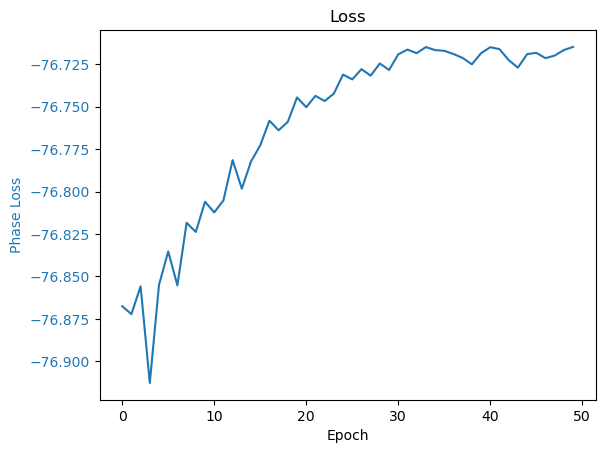

In [15]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [16]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)  # one-hot states for visible units

variables_pha_trained = { "params": state_pha.params, "amp": amp_vars }
phases_model_raw = model_pha.apply(variables_pha_trained, one_hot_states, method=model_pha.compute_phase)

phases_model_wrapped = phases_model_raw % (2 * jnp.pi)

phases_model_tuple = list(zip(one_hot_states, phases_model_raw, phases_model_wrapped))

for state, phase_raw, phase_wrapped in phases_model_tuple:
    bitstring = ''.join('1' if s > 0 else '0' for s in state)
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: 1.7996 (raw), 1.7996 (wrapped)
0100000000: 1.8138 (raw), 1.8138 (wrapped)
0010000000: 1.7994 (raw), 1.7994 (wrapped)
0001000000: 1.8186 (raw), 1.8186 (wrapped)
0000100000: 1.8014 (raw), 1.8014 (wrapped)
0000010000: 1.7983 (raw), 1.7983 (wrapped)
0000001000: 1.8156 (raw), 1.8156 (wrapped)
0000000100: 1.7984 (raw), 1.7984 (wrapped)
0000000010: 1.8145 (raw), 1.8145 (wrapped)
0000000001: 1.8127 (raw), 1.8127 (wrapped)


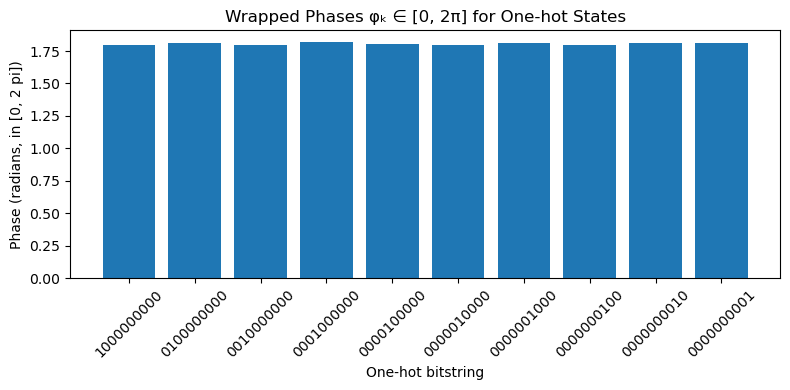

In [17]:
bitstrings = [''.join('1' if val > 0.5 else '0' for val in row) for row in one_hot_states]
phases_np = np.array(phases_model_wrapped)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, phases_np)
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians, in [0, 2 pi])")
ax.set_title("Wrapped Phases φₖ ∈ [0, 2π] for One-hot States")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

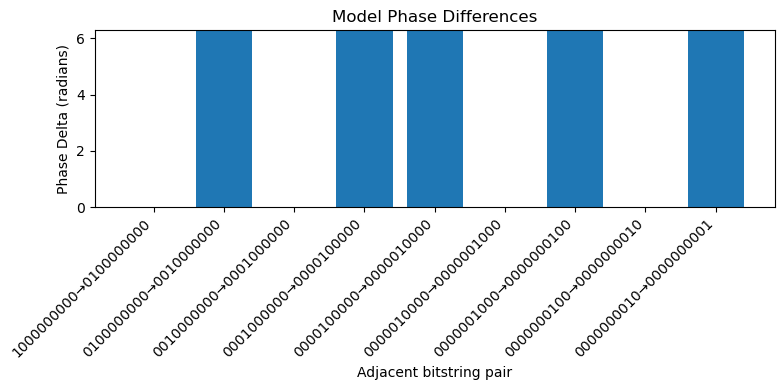

In [18]:

delta = (phases_np[1:] - phases_np[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]}→{bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Model Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()

In [12]:
def load_state_vector_txt(file_path: Path) -> dict:
    state_dict = {}
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            bitstring, rest = line.strip().split(": ")
            complex_str = rest.split(" + ")[0]
            state_dict[bitstring] = complex(complex_str)
    return state_dict


data_dir = Path("data")
file_path_txt = data_dir / "w_aug_state.txt"
state_vector_dict = load_state_vector_txt(file_path_txt)

# use bitstrings to access all one-hot states
reference_amplitudes = [state_vector_dict[bs] for bs in bitstrings]
reference_phases_raw = np.angle(reference_amplitudes)  # get raw phases in radians
reference_phases_wrapped = reference_phases_raw % (2 * jnp.pi)
bitstring_amplitude_pairs = list(zip(bitstrings, reference_amplitudes, reference_phases_raw, reference_phases_wrapped))

# Display the bitstrings and their corresponding phases
for bitstring, amp, phase_raw, phase_wrapped in bitstring_amplitude_pairs:
    print(f"{bitstring}: ampl: {amp:.4f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: ampl: 0.0500-0.3127j (ampl), -1.4122 (raw), 4.8710 (wrapped)
0100000000: ampl: -0.2900+0.1185j (ampl), 2.7537 (raw), 2.7537 (wrapped)
0010000000: ampl: 0.2000-0.2454j (ampl), -0.8870 (raw), 5.3962 (wrapped)
0001000000: ampl: -0.1000-0.2991j (ampl), -1.8935 (raw), 4.3897 (wrapped)
0000100000: ampl: 0.2600+0.1764j (ampl), 0.5961 (raw), 0.5961 (wrapped)
0000010000: ampl: 0.3100-0.0482j (ampl), -0.1544 (raw), 6.1288 (wrapped)
0000001000: ampl: 0.0200-0.3155j (ampl), -1.5075 (raw), 4.7757 (wrapped)
0000000100: ampl: 0.0700-0.3081j (ampl), -1.3474 (raw), 4.9358 (wrapped)
0000000010: ampl: 0.2200+0.2279j (ampl), 0.8031 (raw), 0.8031 (wrapped)
0000000001: ampl: -0.3000+0.0970j (ampl), 2.8289 (raw), 2.8289 (wrapped)


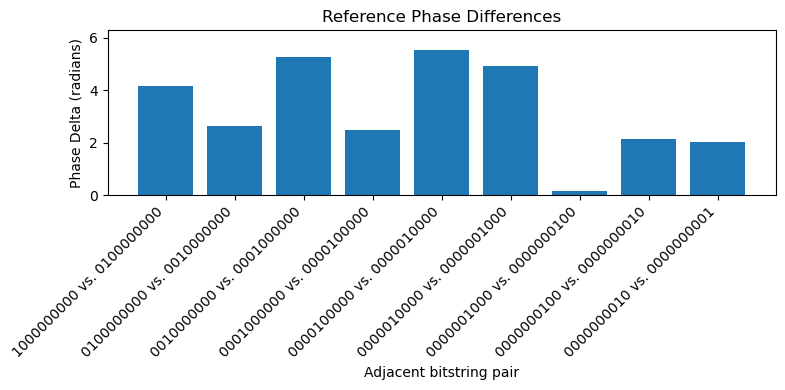

In [13]:
#fig, ax = plt.subplots(figsize=(8, 4))
#ax.bar(bitstrings, reference_phases_wrapped)
#ax.set_xlabel("One-hot bitstring")
#ax.set_ylabel("Phase (radians)")
#ax.set_title("Reference Phases")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

delta = (reference_phases_wrapped[1:] - reference_phases_wrapped[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]} vs. {bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Reference Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()